In [1]:
!pip install -U segmentation-models --quiet

In [2]:
import tensorflow as tf
import os
import json
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook
import albumentations as albu
from skimage.exposure import adjust_gamma
import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import segmentation_models as sm
from segmentation_models.utils import set_trainable

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
data_dir = '../input/understanding_cloud_organization/'

In [4]:
train_df = pd.read_csv(f'{data_dir}train.csv')
train_df['ImageId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(22184, 5)


,Image_Label,EncodedPixels,ImageId,ClassId,hasMask
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,True
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,True
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel,False
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar,False
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,True


In [5]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(5546, 2)


,ImageId,hasMask
821,24dd99c.jpg,4.0
1885,562f80a.jpg,4.0
3260,944f10b.jpg,4.0
1872,55b539f.jpg,4.0
4464,cdf7242.jpg,4.0


In [6]:
sub_df = pd.read_csv(f'{data_dir}/sample_submission.csv')
sub_df['ImageId'] = sub_df['Image_Label'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

In [7]:
def np_resize(img, input_shape):
    """
    Reshape a numpy array, which is input_shape=(height, width), 
    as opposed to input_shape=(width, height) for cv2
    """
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

In [8]:
class RAdam(keras.optimizers.Optimizer):
    """RAdam optimizer.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Weight decay for each param.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
        total_steps: int >= 0. Total number of training steps. Enable warmup by setting a positive value.
        warmup_proportion: 0 < warmup_proportion < 1. The proportion of increasing steps.
        min_lr: float >= 0. Minimum learning rate after warmup.
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        - [On The Variance Of The Adaptive Learning Rate And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf)
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0., amsgrad=False,
                 total_steps=0, warmup_proportion=0.1, min_lr=0., **kwargs):
        super(RAdam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.weight_decay = K.variable(weight_decay, name='weight_decay')
            self.total_steps = K.variable(total_steps, name='total_steps')
            self.warmup_proportion = K.variable(warmup_proportion, name='warmup_proportion')
            self.min_lr = K.variable(min_lr, name='min_lr')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.initial_weight_decay = weight_decay
        self.initial_total_steps = total_steps
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        if self.initial_total_steps > 0:
            warmup_steps = self.total_steps * self.warmup_proportion
            lr = K.switch(
                t <= warmup_steps,
                lr * (t / warmup_steps),
                self.min_lr + (lr - self.min_lr) * (1.0 - K.minimum(t, self.total_steps) / self.total_steps),
            )

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]

        self.weights = [self.iterations] + ms + vs + vhats

        beta_1_t = K.pow(self.beta_1, t)
        beta_2_t = K.pow(self.beta_2, t)

        sma_inf = 2.0 / (1.0 - self.beta_2) - 1.0
        sma_t = sma_inf - 2.0 * t * beta_2_t / (1.0 - beta_2_t)

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            m_corr_t = m_t / (1.0 - beta_1_t)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                v_corr_t = K.sqrt(vhat_t / (1.0 - beta_2_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                v_corr_t = K.sqrt(v_t / (1.0 - beta_2_t) + self.epsilon)

            r_t = K.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                         (sma_t - 2.0) / (sma_inf - 2.0) *
                         sma_inf / sma_t)

            p_t = K.switch(sma_t >= 5, r_t * m_corr_t / v_corr_t, m_corr_t)

            if self.initial_weight_decay > 0:
                p_t += self.weight_decay * p

            p_t = p - lr * p_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {
            'lr': float(K.get_value(self.lr)),
            'beta_1': float(K.get_value(self.beta_1)),
            'beta_2': float(K.get_value(self.beta_2)),
            'decay': float(K.get_value(self.decay)),
            'weight_decay': float(K.get_value(self.weight_decay)),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
            'total_steps': float(K.get_value(self.total_steps)),
            'warmup_proportion': float(K.get_value(self.warmup_proportion)),
            'min_lr': float(K.get_value(self.min_lr)),
        }
        base_config = super(RAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [9]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path=f'{data_dir}train_images',
                 batch_size=32, dim=(1400, 2100), n_channels=3, reshape=None,
                 augment=False, n_classes=4, random_state=42, shuffle=True, gamma=None):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.n_channels = n_channels
        self.augment = augment
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        self.gamma = gamma
        self.on_epoch_end()
        np.random.seed(self.random_state)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_rgb(img_path)
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape)
            
            if self.gamma is not None:
                img = adjust_gamma(img, gamma=self.gamma)
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img
    
    
    def __random_transform(self, img, masks):
        composition = albu.Compose([
            albu.HorizontalFlip(),
            albu.VerticalFlip(),
            albu.ShiftScaleRotate(rotate_limit=30, shift_limit=0.1)
        ])
        
        composed = composition(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']
        
        return aug_img, aug_masks
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__random_transform(
                img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch

In [10]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [11]:
le = LabelEncoder()
kf = StratifiedKFold(n_splits=5)
split_idx = kf.split(mask_count_df.index, le.fit_transform(mask_count_df.values[:,1]))

t = [(mask_count_df.index[train], mask_count_df.index[test]) for i, (train,test) in enumerate(split_idx) if i == 0]
train_idx, val_idx = t[0][0], t[0][1]

train_idx, val_idx = train_test_split(
    mask_count_df.index, random_state=42, test_size=0.20
)

In [12]:
val_idx

Int64Index([ 821, 1885, 3260, 1872, 4464,  716, 5330, 4473, 4116,  468,
            ...
            5175,  406,  440, 5171,  379, 5150,  342,  368,  488,  489],
           dtype='int64', length=1111)

In [13]:
train_df.head()

,Image_Label,EncodedPixels,ImageId,ClassId,hasMask
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,True
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,True
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel,False
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar,False
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,True


In [14]:
BATCH_SIZE = 16

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    reshape=(320, 480),
    augment=True,
    n_channels=3,
    n_classes=4,
    gamma = 0.8
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    shuffle=False,
    reshape=(320, 480),
    augment=False,
    n_channels=3,
    n_classes=4,
    gamma = 0.8
)

In [15]:
model = sm.Unet(backbone_name = 'resnet34', encoder_weights='imagenet',
    classes=4,
    input_shape=(320, 480, 3),
    activation='sigmoid',encoder_freeze=True)


model.compile(optimizer=RAdam(), loss=bce_dice_loss, metrics=[dice_coef])
model.summary()

85524480/85521592 [==============================] - 4s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 320, 480, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 326, 486, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 160, 240, 64) 9408        zero_padding2d_1[0][0]           
____________________________________________

In [16]:
checkpoint = ModelCheckpoint('res34_unet_freeze.h5', save_best_only=True)
es = EarlyStopping(monitor='val_dice_coef', patience=4, verbose=1, mode='max', restore_best_weights=True)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, es],
    epochs=12
)

Epoch 1/12
277/277 [==============================] - 778s 3s/step - loss: 1.1311 - dice_coef: 0.3403 - val_loss: 0.9801 - val_dice_coef: 0.4265
Epoch 2/12
277/277 [==============================] - 711s 3s/step - loss: 0.9028 - dice_coef: 0.4458 - val_loss: 0.8945 - val_dice_coef: 0.4998
Epoch 3/12
277/277 [==============================] - 711s 3s/step - loss: 0.8596 - dice_coef: 0.4783 - val_loss: 0.8902 - val_dice_coef: 0.4954
Epoch 4/12
277/277 [==============================] - 741s 3s/step - loss: 0.8355 - dice_coef: 0.4948 - val_loss: 0.8182 - val_dice_coef: 0.5033
Epoch 5/12
277/277 [==============================] - 708s 3s/step - loss: 0.8235 - dice_coef: 0.5034 - val_loss: 0.7993 - val_dice_coef: 0.5294
Epoch 6/12
277/277 [==============================] - 720s 3s/step - loss: 0.8166 - dice_coef: 0.5081 - val_loss: 0.8306 - val_dice_coef: 0.5085
Epoch 7/12
277/277 [==============================] - 713s 3s/step - loss: 0.8067 - dice_coef: 0.5140 - val_loss: 0.8168 - val_dic

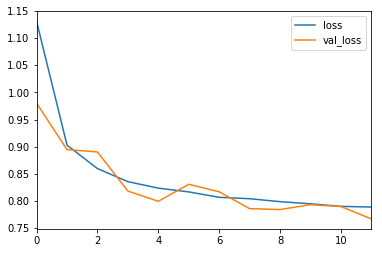

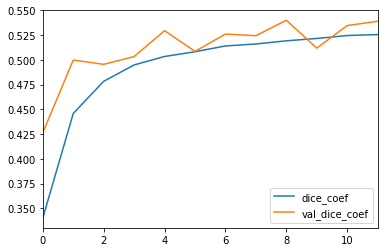

In [17]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

In [18]:
del history_df

In [19]:
model.load_weights('res34_unet_freeze.h5')
set_trainable(model)
model.compile(optimizer=RAdam(lr=0.0007), loss=bce_dice_loss, metrics=[dice_coef])

checkpoint = ModelCheckpoint('res34_unet_unfreeze.h5', save_best_only=True)
es = EarlyStopping(monitor='val_dice_coef', patience=8, verbose=1, mode='max', restore_best_weights=True)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    reshape=(320, 480),
    augment=True,
    n_channels=3,
    n_classes=4,
    gamma = 0.8
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    reshape=(320, 480),
    augment=False,
    n_channels=3,
    n_classes=4,
    gamma = 0.8
)


history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, es],
    epochs=15
)



Epoch 1/15
277/277 [==============================] - 701s 3s/step - loss: 0.7977 - dice_coef: 0.5193 - val_loss: 0.8495 - val_dice_coef: 0.5006
Epoch 2/15
277/277 [==============================] - 688s 2s/step - loss: 0.7958 - dice_coef: 0.5183 - val_loss: 0.8297 - val_dice_coef: 0.5110
Epoch 3/15
277/277 [==============================] - 1034s 4s/step - loss: 0.7928 - dice_coef: 0.5216 - val_loss: 0.8909 - val_dice_coef: 0.4831
Epoch 4/15
277/277 [==============================] - 716s 3s/step - loss: 0.7919 - dice_coef: 0.5212 - val_loss: 0.8030 - val_dice_coef: 0.5228
Epoch 5/15
277/277 [==============================] - 783s 3s/step - loss: 0.7883 - dice_coef: 0.5242 - val_loss: 0.7797 - val_dice_coef: 0.5291
Epoch 6/15
277/277 [==============================] - 792s 3s/step - loss: 0.7815 - dice_coef: 0.5292 - val_loss: 0.8559 - val_dice_coef: 0.5062
Epoch 7/15
277/277 [==============================] - 740s 3s/step - loss: 0.7766 - dice_coef: 0.5321 - val_loss: 0.8184 - val_di

In [20]:
with open('history_2.json', 'w') as f:
    json.dump(history.history, f)


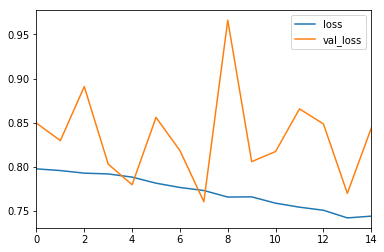

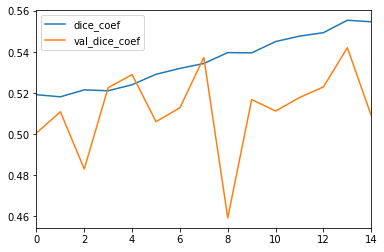

In [21]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

In [22]:
model.load_weights('res34_unet_unfreeze.h5')

In [23]:

test_df = []

for i in range(0, test_imgs.shape[0], 500):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + 500))
    )

    test_generator = DataGenerator(
        batch_idx,
        df=test_imgs,
        shuffle=False,
        mode='predict',
        dim=(350, 525),
        reshape=(320, 480),
        n_channels=3,
        base_path=f'{data_dir}test_images',
        target_df=sub_df,
        batch_size=1,
        n_classes=4,
        gamma = 0.8
    )

    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1
    )

    for j, b in enumerate(batch_idx):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()

        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))

        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)

198/198 [==============================] - 20s 103ms/step


In [24]:
test_df = pd.concat(test_df)
test_df.drop(columns='ImageId', inplace=True)
test_df.to_csv('res32-unet.csv', index=False)